In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
import pandas as pd
import tensorflow as tf
import math
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
import cv2
import numpy as np

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Device:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Device: /device:GPU:0


In [ ]:
def mask_generator(im):
  imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  _,thresh = cv2.threshold(imgray,127,255,0)
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  ellipse = cv2.fitEllipse(contours[0])
  return cv2.ellipse(im,ellipse,(255,255,255),-1)

In [6]:
train_dataset_paths = sorted(glob.glob("/content/drive/MyDrive/1327317/training_set/*.png"))
image_paths = [p for p in train_dataset_paths if "Annotation" not in p]
mask_paths = [ p for p in train_dataset_paths if "Annotation" in p]

In [7]:
print(len(mask_paths))

999


In [8]:
print(mask_paths[0])

/content/drive/MyDrive/1327317/training_set/000_HC_Annotation.png


In [ ]:
import os
output_path = "/content/drive/MyDrive/1327317/training_set/mask"

for idx, path in enumerate(mask_paths):
    im = cv2.imread(path)
    mask = mask_generator(im)

    filename = f"{idx:03d}_mask.png"
    save_path = os.path.join(output_path, filename)

    cv2.imwrite(save_path, mask)


In [9]:
mask_paths = sorted(glob.glob("/content/drive/MyDrive/1327317/training_set/mask/*.png"))
print(len(mask_paths))

999


In [10]:
def load_dataset(images,masks):

  train_x, temp_x, train_y, temp_y = train_test_split(images, masks, test_size=0.2, random_state=42)
  val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)
  return (train_x, test_x), (train_y, test_y), (val_x, val_y)

Training dataset:


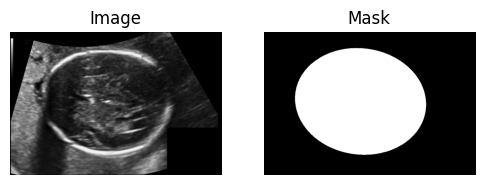

test dataset:


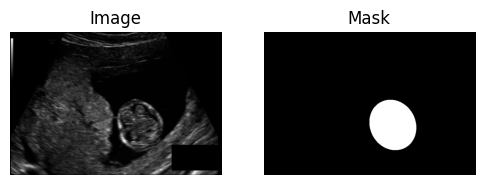

val dataset:


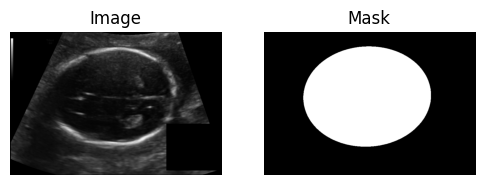

In [11]:
(train_x, test_x), (train_y, test_y), (val_x, val_y) = load_dataset(image_paths,mask_paths)
def show_image_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title("Image")
    ax1.axis("off")

    ax2.imshow(mask, cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.show()

print("Training dataset:")
show_image_mask(train_x[0], train_y[0])


print("test dataset:")
show_image_mask(test_x[0], test_y[0])

print("val dataset:")
show_image_mask(val_x[0], val_y[0])

In [12]:
print(len(train_x), len(val_x), len(test_x))

799 100 100


In [13]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x.astype(np.float32)
  x = x/255.0
  return x

In [14]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x.astype(np.float32)
  x = x/255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [15]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)

    y = read_mask(y)
    return x,y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y

def tf_dataset(X,Y,batch = 16):
  dataset = tf.data.Dataset.from_tensor_slices((X,Y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(10)
  return dataset

In [16]:
train_dataset = tf_dataset(train_x, train_y, batch=32)
val_dataset = tf_dataset(val_x, val_y, batch=32)
test_dataset = tf_dataset(test_x, test_y, batch=32)

In [17]:
for x,y in train_dataset:
  print(x.shape, y.shape)
  break

(32, 256, 256, 3) (32, 256, 256, 1)


In [18]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [19]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [20]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (256 x 256)
    s2 = vgg16.get_layer("block2_conv2").output         ## (128x 128)
    s3 = vgg16.get_layer("block3_conv3").output         ## (64 x 64)
    s4 = vgg16.get_layer("block4_conv3").output         ## (32 x 32)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (32 x 32)
    d2 = decoder_block(d1, s3, 256)                     ## (64 x 64)
    d3 = decoder_block(d2, s2, 128)                     ## (128 x 128)
    d4 = decoder_block(d3, s1, 64)                      ## (256 x 256)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net_test")
    return model

In [ ]:
model = build_vgg16_unet((256, 256, 3))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "VGG16_U-Net_test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,862,337 (98.66 MB)

 Trainable params: 25,858,497 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [21]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef])

In [ ]:
model_path = "/content/drive/MyDrive/1327317/model.keras"

In [ ]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only= True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs= 50,
    validation_data= val_dataset,
    callbacks= callback
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - dice_coef: 0.5890 - loss: 0.4110 
Epoch 1: val_loss improved from inf to 0.53975, saving model to /content/drive/MyDrive/1327317/model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 746s 26s/step - dice_coef: 0.5936 - loss: 0.4064 - val_dice_coef: 0.4566 - val_loss: 0.5397 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.8354 - loss: 0.1646
Epoch 2: val_loss improved from 0.53975 to 0.52298, saving model to /content/drive/MyDrive/1327317/model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - dice_coef: 0.8362 - loss: 0.1638 - val_dice_coef: 0.4736 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.8893 - loss: 0.1107
Epoch 3: val_loss improved from 0.52298 to 0.45780, saving model to /content/drive/MyDrive/1327317/model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - dice_coef: 0.8898 - loss: 0.1102 - val_dice_coef: 0.5374 - val_loss: 0.4578 - learning_rate:

In [ ]:
def plot_loss_and_dice(history):
    plt.figure(figsize=(12, 5))

    #Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    #  Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.show()

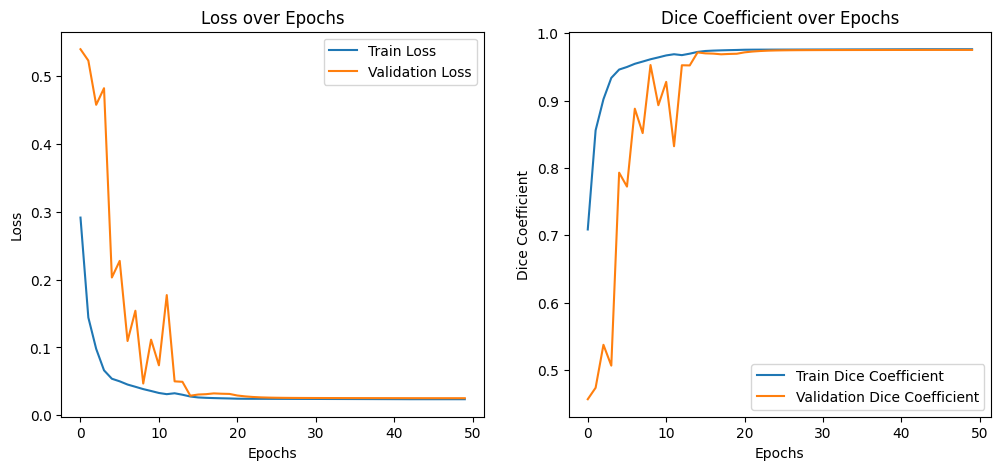

In [ ]:
plot_loss_and_dice(history)

In [23]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/1327317/model.keras', custom_objects={
    'dice_loss': dice_loss,
    'dice_coef': dice_coef
})
model.summary()

Model: "VGG16_U-Net_test"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 77,579,333 (295.94 MB)

 Trainable params: 25,858,497 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 51,716,996 (197.28 MB)

In [ ]:
print(test_x[0])

/content/drive/MyDrive/1327317/training_set/071_HC.png


In [ ]:
test_iterator = iter(test_dataset)
first_element = next(test_iterator)
first_input, first_label = first_element
print(first_input.shape, first_label.shape)
predict_mask_test = model.predict(first_input)

(32, 256, 256, 3) (32, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step


In [ ]:
np.max(predict_mask_test[5])

0.99999917

In [ ]:
print(np.unique(mask_test_5))

[0 1]


In [ ]:
mask_test_5 = np.where(predict_mask_test[5] >= 0.5, 1, 0)

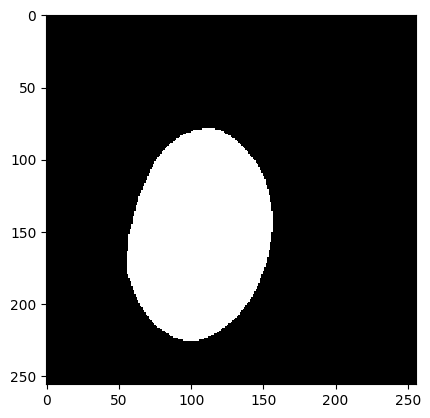

In [ ]:
plt.imshow(mask_test_5, cmap='gray', interpolation='nearest')
plt.show()

<class 'tensorflow.python.framework.ops.EagerTensor'>


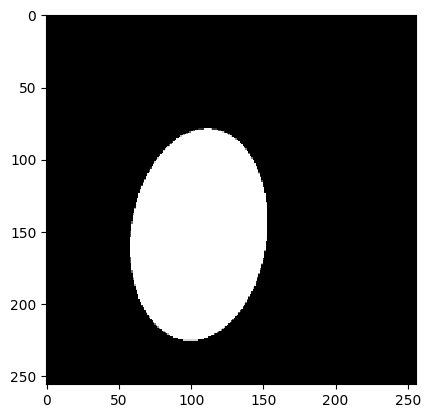

In [ ]:
print(type(first_label[0]))
first_label[5].numpy().squeeze()
plt.imshow(first_label[5], cmap='gray', interpolation='nearest')

(32, 256, 256, 3)
(256, 256, 3)


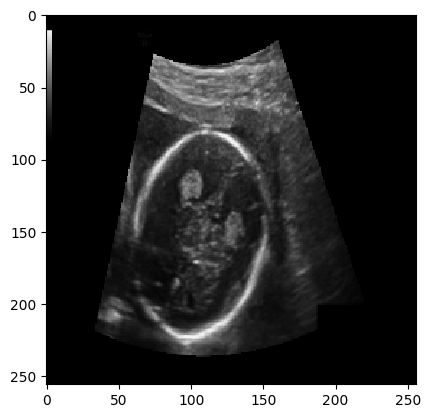

In [ ]:
type(first_input)
print(first_input.shape)
check = first_input[5].numpy().squeeze()
print(check.shape)
plt.imshow(first_input[5], interpolation='nearest')

In [ ]:
def display_image(image_list):
  plt.figure(figsize =(15,15))
  title = ["Input Image", "Label", "Predicted Mask"]
  for i in range(len(image_list)):
    plt.subplot(1,len(image_list), i+1)
    plt.title(title[i])
    plt.imshow(image_list[i], cmap='gray', interpolation='nearest')
    plt.axis('off')
  plt.show()

In [ ]:
def show_prediction(dataset = None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      pred_mask_first = pred_mask[0]
      pred_mask_normalize = np.where(pred_mask_first >= 0.5 , 1, 0)
      image_array = image[0].numpy().squeeze()
      mask_array = mask[0].numpy().squeeze()
      display_image([image_array,mask_array, pred_mask_normalize])

1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step


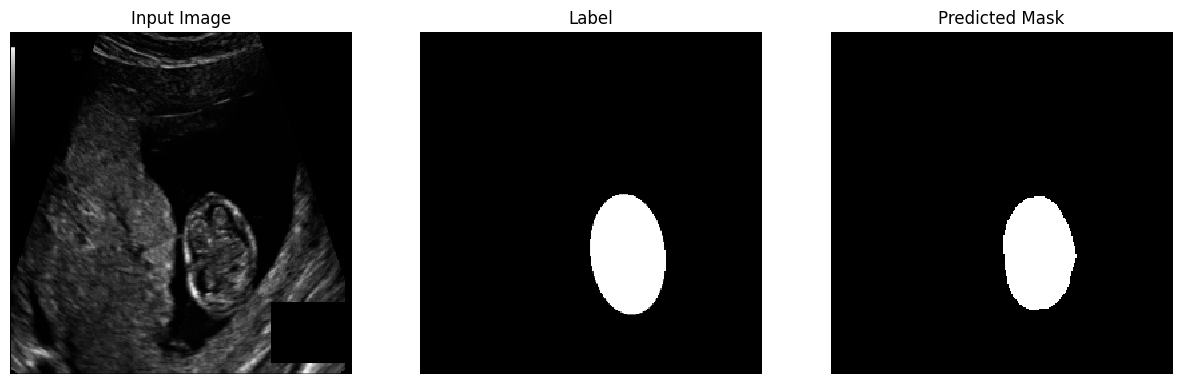

1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step


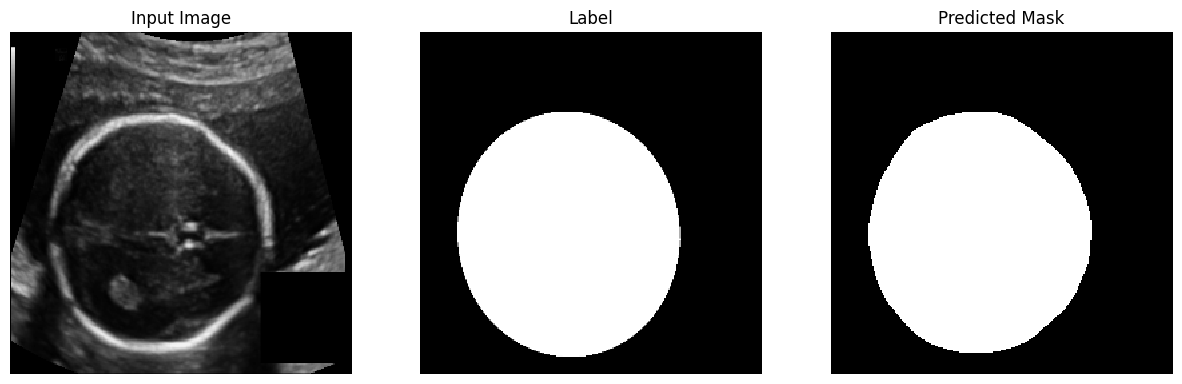

1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step


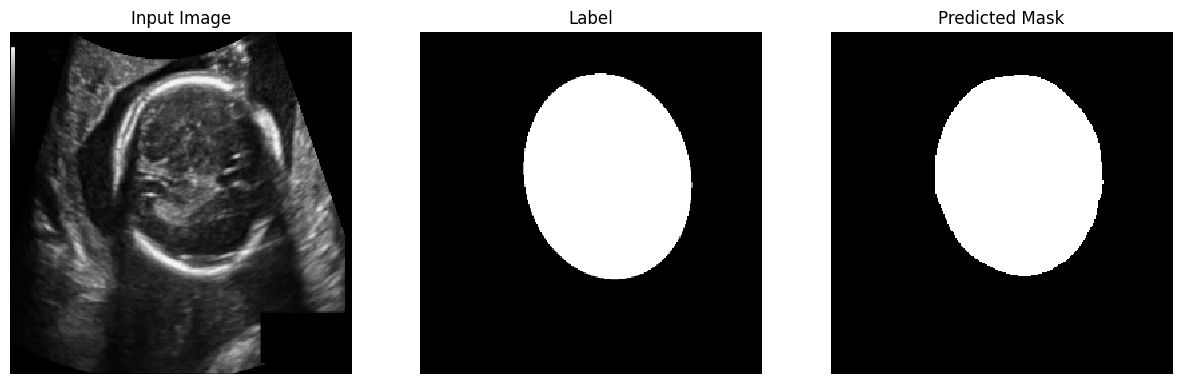

In [ ]:
show_prediction(test_dataset,3)

In [ ]:
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


In [24]:
all_predict = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step


In [30]:
output_dir = "/content/drive/MyDrive/1327317/mask_test"
print(f"Output directory: {output_dir}")

Output directory: /content/drive/MyDrive/1327317/mask_test


In [79]:
import os
for i, filename in enumerate(test_x):
  mask = np.where(all_predict[i] >= 0.5 ,1,0).astype(np.uint8)
  mask_resized = cv2.resize(mask, (800, 540), interpolation=cv2.INTER_NEAREST)
  basename = os.path.basename(filename)
  output_filename = os.path.join(output_dir, f"{os.path.splitext(basename)[0]}.png")
  cv2.imwrite(output_filename, mask_resized * 255)
  print(f"Saved mask for {filename} to {output_filename}")

Saved mask for /content/drive/MyDrive/1327317/training_set/071_HC.png to /content/drive/MyDrive/1327317/mask_test/071_HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/059_HC.png to /content/drive/MyDrive/1327317/mask_test/059_HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/482_3HC.png to /content/drive/MyDrive/1327317/mask_test/482_3HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/360_2HC.png to /content/drive/MyDrive/1327317/mask_test/360_2HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/289_HC.png to /content/drive/MyDrive/1327317/mask_test/289_HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/243_HC.png to /content/drive/MyDrive/1327317/mask_test/243_HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/716_HC.png to /content/drive/MyDrive/1327317/mask_test/716_HC.png
Saved mask for /content/drive/MyDrive/1327317/training_set/377_HC.png to /content/drive/MyDrive/1327317/mask_test/377_HC.

In [80]:
Y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0).astype(np.float32)
print(Y_test.shape)

(100, 256, 256, 1)


In [102]:
X_test = np.concatenate([x.numpy() for x, y in test_dataset], axis=0).astype(np.float32)
print(X_test.shape)
print(type(X_test))

(100, 256, 256, 3)
<class 'numpy.ndarray'>


In [81]:
y_pred_thresholded = (all_predict > 0.5).astype(np.float32)

In [82]:
dice_scores = [dice_coef(y_true, y_pred).numpy() for y_true, y_pred in zip(Y_test, y_pred_thresholded)]
mean_dice = np.mean(dice_scores)
print(f"Mean Dice Score on test set: {mean_dice:.4f}")

Mean Dice Score on test set: 0.9624


In [83]:
def fit_ellipse(im):
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [84]:
df_train = pd.read_csv('/content/drive/MyDrive/1327317/training_set_pixel_size_and_HC.csv')
df_train.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [85]:
HC_test_dataset = {'filename': [], 'semi_axes_a_mm': [], 'semi_axes_b_mm': [], 'HC_real_mm': []}

file_names = sorted([file for _, _, files in os.walk('/content/drive/MyDrive/1327317/mask_test') for file in files])

for file_name in file_names:
    im = cv2.imread(f'/content/drive/MyDrive/1327317/mask_test/{file_name}')
    ellipse = fit_ellipse(im)

    pixel_size = df_train.loc[df_train['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    semi_axes_b, semi_axes_a = ellipse[1]
    hc_real_value = df_train.loc[df_train['filename'] == file_name, 'head circumference (mm)']

    if semi_axes_b > semi_axes_a:
        semi_axes_a, semi_axes_b = semi_axes_b, semi_axes_a

    HC_test_dataset['filename'].append(file_name)
    HC_test_dataset['semi_axes_a_mm'].append(semi_axes_a * pixel_size / 2)
    HC_test_dataset['semi_axes_b_mm'].append(semi_axes_b * pixel_size / 2)
    HC_test_dataset['HC_real_mm'].append(hc_real_value.values[0])

HC_test_dataset = pd.DataFrame(HC_test_dataset)
HC_test_dataset = HC_test_dataset[['filename', 'semi_axes_a_mm', 'semi_axes_b_mm', 'HC_real_mm']]

HC_test_dataset.to_csv("/content/drive/MyDrive/1327317/HC_test_dataset.csv")
print('creat HC_test_dataset successful!')


creat HC_test_dataset successful!


In [113]:
print(file_names)

['010_2HC.png', '020_HC.png', '031_HC.png', '044_HC.png', '052_HC.png', '056_HC.png', '059_HC.png', '061_2HC.png', '064_2HC.png', '071_HC.png', '090_HC.png', '110_HC.png', '113_HC.png', '126_HC.png', '133_HC.png', '138_2HC.png', '165_HC.png', '166_HC.png', '175_HC.png', '191_HC.png', '199_HC.png', '201_HC.png', '209_HC.png', '213_HC.png', '223_2HC.png', '225_2HC.png', '225_HC.png', '231_HC.png', '233_HC.png', '237_3HC.png', '237_HC.png', '243_3HC.png', '243_HC.png', '246_HC.png', '252_HC.png', '255_HC.png', '260_HC.png', '261_HC.png', '276_2HC.png', '277_HC.png', '282_HC.png', '289_HC.png', '294_2HC.png', '299_2HC.png', '306_HC.png', '308_HC.png', '322_HC.png', '345_2HC.png', '352_2HC.png', '352_HC.png', '360_2HC.png', '377_HC.png', '411_HC.png', '420_HC.png', '425_HC.png', '426_4HC.png', '426_HC.png', '428_HC.png', '433_HC.png', '439_HC.png', '449_HC.png', '468_2HC.png', '469_2HC.png', '477_HC.png', '479_HC.png', '482_3HC.png', '484_HC.png', '499_HC.png', '513_HC.png', '526_HC.png', '

In [86]:
print(HC_test_dataset)

       filename  semi_axes_a_mm  semi_axes_b_mm  HC_real_mm
0   010_2HC.png       14.502197       10.835451       72.87
1    020_HC.png       11.761162        9.629067       68.41
2    031_HC.png       10.185797        9.244436       67.10
3    044_HC.png       11.837431        4.587062       69.49
4    052_HC.png       15.459576       10.925262       71.91
..          ...             ...             ...         ...
95   746_HC.png       53.017844       38.378774      282.40
96   751_HC.png       53.546569       43.450639      306.10
97   758_HC.png       59.022297       46.415860      324.00
98   767_HC.png       51.991866       43.081757      303.18
99   785_HC.png       50.781788       47.789031      311.16

[100 rows x 4 columns]


In [87]:
def calculate_HC(a, b):
    return np.pi * (3 * (a + b) - np.sqrt((3 * a + b) * (a + 3 * b)))
HC_test_dataset["HC_mm"] = HC_test_dataset.apply(lambda row: calculate_HC(row["semi_axes_a_mm"], row["semi_axes_b_mm"]), axis=1)

output_path = "/content/drive/MyDrive/1327317/HC_test_dataset.csv"
HC_test_dataset.to_csv(output_path, index=False)

print("done")

done


In [88]:
HC_test_dataset.head()

,filename,semi_axes_a_mm,semi_axes_b_mm,HC_real_mm,HC_mm
0,010_2HC.png,14.502197,10.835451,72.87,80.017875
1,020_HC.png,11.761162,9.629067,68.41,67.366402
2,031_HC.png,10.185797,9.244436,67.10,61.077705
3,044_HC.png,11.837431,4.587062,69.49,54.144178
4,052_HC.png,15.459576,10.925262,71.91,83.503557


In [89]:
mse = np.mean((HC_test_dataset['HC_real_mm'] - HC_test_dataset['HC_mm'])**2)
print(f"MSE: {mse:.4f}")
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

MSE: 14.6649
RMSE: 3.8295


In [90]:
mean_HC = HC_test_dataset['HC_real_mm'].mean()
print(f"Mean of Ground truth HC: {mean_HC:.4f} mm")

Mean of Ground truth HC: 174.2754 mm


In [93]:
print(f"Percentage Of error between RMSE and Mean_HC: {rmse/mean_HC * 100: .2f}%")

Percentage Of error between RMSE and Mean_HC:  2.20%


In [95]:
test_dataset_paths = sorted(glob.glob("/content/drive/MyDrive/1327317/test_set/*.png"))
print(len(test_dataset_paths))
print(test_dataset_paths[0])


335
/content/drive/MyDrive/1327317/test_set/000_HC.png


In [99]:
X_new = []
for img_path in test_dataset_paths :
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    X_new.append(img)

X_new = np.array(X_new)

In [103]:
Y_new = model.predict(X_new)

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step


In [107]:
print(X_new.shape)
print(Y_new.shape)

(335, 256, 256, 3)
(335, 256, 256, 1)


In [104]:
new_path = "/content/drive/MyDrive/1327317/new_data"
print(f"Output directory: {new_path}")

Output directory: /content/drive/MyDrive/1327317/new_data


In [ ]:
for i, filename in enumerate(test_dataset_paths):
  mask = np.where(Y_new[i] >= 0.5 ,1,0).astype(np.uint8)
  mask_resized = cv2.resize(mask, (800, 540), interpolation=cv2.INTER_NEAREST)
  basename = os.path.basename(filename)
  output_filename = os.path.join(new_path, f"{os.path.splitext(basename)[0]}.png")
  cv2.imwrite(output_filename, mask_resized * 255)
  print(f"Saved mask for {filename} to {output_filename}")

In [112]:
df_test = pd.read_csv('/content/drive/MyDrive/1327317/test_set_pixel_size.csv')
df_test.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [120]:
import os
new_file_names = sorted([file for _, _, files in os.walk('/content/drive/MyDrive/1327317/new_data') for file in files])
print(new_file_names)

['000_HC.png', '001_HC.png', '002_HC.png', '003_HC.png', '004_HC.png', '005_HC.png', '006_HC.png', '007_HC.png', '008_HC.png', '009_HC.png', '010_HC.png', '011_HC.png', '012_HC.png', '013_HC.png', '014_HC.png', '015_HC.png', '016_HC.png', '017_HC.png', '018_HC.png', '019_HC.png', '020_HC.png', '021_HC.png', '022_HC.png', '023_HC.png', '024_HC.png', '025_HC.png', '026_HC.png', '027_HC.png', '028_HC.png', '029_HC.png', '030_HC.png', '031_HC.png', '032_HC.png', '033_HC.png', '034_HC.png', '035_HC.png', '036_HC.png', '037_HC.png', '038_HC.png', '039_HC.png', '040_HC.png', '041_HC.png', '042_HC.png', '043_HC.png', '044_HC.png', '045_HC.png', '046_HC.png', '047_HC.png', '048_HC.png', '049_HC.png', '050_HC.png', '051_HC.png', '052_HC.png', '053_HC.png', '054_HC.png', '055_HC.png', '056_HC.png', '057_HC.png', '058_HC.png', '059_HC.png', '060_HC.png', '061_HC.png', '062_HC.png', '063_HC.png', '064_HC.png', '065_HC.png', '066_HC.png', '067_HC.png', '068_HC.png', '069_HC.png', '070_HC.png', '071_

In [127]:
semi_axes_a_mm = []
semi_axes_b_mm = []
for filename in new_file_names:
    im = cv2.imread(f'/content/drive/MyDrive/1327317/new_data/{filename}')
    ellipse = fit_ellipse(im)
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_a, semi_axes_b = semi_axes_b, semi_axes_a
    pixel_size = df_test.loc[df_test['filename'] == filename, 'pixel size(mm)'].iloc[0]
    semi_axes_a_mm.append(semi_axes_a * pixel_size / 2)
    semi_axes_b_mm.append(semi_axes_b * pixel_size / 2)

df_test['semi_axes_a_mm'] = semi_axes_a_mm
df_test['semi_axes_b_mm'] = semi_axes_b_mm
print("done")



done


In [128]:
df_test["HC_mm"] = df_test.apply(lambda row: calculate_HC(row["semi_axes_a_mm"], row["semi_axes_b_mm"]), axis=1)

output_path = "/content/drive/MyDrive/1327317/test_dataset_full.csv"
HC_test_dataset.to_csv(output_path, index=False)
print("done")

done


In [129]:
print(df_test)

       filename  pixel size(mm)  semi_axes_a_mm  semi_axes_b_mm       HC_mm
0    000_HC.png        0.235857       54.058344       41.226281  300.704272
1    001_HC.png        0.067973       11.887288       10.584355   70.656092
2    002_HC.png        0.165202       37.677445       29.159626  210.828287
3    003_HC.png        0.096674       30.651951       22.951022  169.268767
4    004_HC.png        0.202203       58.660285       43.031338  321.362983
..          ...             ...             ...             ...         ...
330  330_HC.png        0.138479       34.728301       27.360809  195.745912
331  331_HC.png        0.075739       14.646398       11.061936   81.158113
332  332_HC.png        0.113107       31.141098       24.840146  176.427712
333  333_HC.png        0.219140       33.581552       28.139999  194.280943
334  334_HC.png        0.112421       31.393900       22.774135  171.252914

[335 rows x 5 columns]
